In [2]:
import gc
import os
import re
import xml.etree.ElementTree as ET
from collections import Counter, defaultdict

import h5py
import joblib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from Bio import Align, SeqIO, AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import Seq
from scipy.stats import binomtest, gaussian_kde
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from transformers import T5EncoderModel, T5Tokenizer

sns.set_theme("paper")
# increase font size
sns.set(font_scale=1.5)

## Select good C-terminal alignments


In [18]:
all_aligns = AlignIO.read("../data/ucyn-a_enriched/ucyn-a_enriched_cobalt_cleaned.fa", "fasta")

c_term_start = 880
c_term_end = 1010
align_len = c_term_end - c_term_start

good_aligns = []
good_aligns_full = []
for align in all_aligns:
    full_id = align.id
    id = " ".join(align.description.split(" ")[1:])
    align.id = id
    align.description = ""
    seq = str(align.seq)
    c_term_seq = seq[c_term_start : c_term_end + 1]
    c_term_no_gaps = "".join([char for char in c_term_seq if char != "-"])
    if len(c_term_no_gaps) / align_len > 0.6:
        good_aligns.append(
            SeqIO.SeqRecord(Seq(seq[c_term_start:]), id=id, description="")
        )
        full_seq = str(align.seq).replace("-", "")
        good_aligns_full.append(SeqIO.SeqRecord(Seq(full_seq), id=id, description=""))

SeqIO.write(good_aligns, "../data/utp-data/good-c-term.fasta", "fasta")
SeqIO.write(good_aligns_full, "../data/utp-data/good-c-term-full.fasta", "fasta")

206

In [32]:
msa = AlignIO.read("../data/ucyn-a_enriched/ucyn-a_enriched_cobalt_cleaned.fa", "fasta")
summary_align = AlignInfo.SummaryInfo(msa)

conservation = []
for i in range(all_aligns.get_alignment_length()):
    column = all_aligns[:, i]
    conservation.append(summary_align.information_content(i, chars_to_ignore=['-']))

# Create the plot
plt.figure(figsize=(15, 5))
plt.plot(range(1, len(conservation) + 1), conservation)
plt.title("Sequence Conservation Across Aligned Sequences")
plt.xlabel("Alignment Position")
plt.ylabel("Conservation (bits)")
plt.ylim(0, 4)  # Maximum conservation for protein sequences is log2(20) ≈ 4.32 bits
plt.grid(True, linestyle='--', alpha=0.7)

# Add some styling
plt.fill_between(range(1, len(conservation) + 1), conservation, alpha=0.3)
plt.tight_layout()

plt.show()

AttributeError: 'Alignment' object has no attribute 'get_alignment_length'

In [47]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    summary_align = AlignInfo.SummaryInfo(msa)
    consensus = summary_align.dumb_consensus()
    scores = []

    for i in range(msa.get_alignment_length()):
        column = msa[:, i]
        score = sum(1 for residue in column if residue == consensus[i]) / len(column)
        scores.append(score)


In [3]:
# Fix Gblocks output IDs
c_terms_gb = list(SeqIO.parse("../data/utp-data/good-c-term-gb.fasta", "fasta"))
ids = set([record.id for record in SeqIO.parse("../data/utp-data/good-c-term.fasta", "fasta")])

for record in c_terms_gb:
    correct_id = next((i for i in ids if i.replace("-", "") == record.id), None)
    if correct_id is not None:
        record.id = correct_id  
        record.description = ""

SeqIO.write(c_terms_gb, "../data/utp-data/good-c-term-gb.fasta", "fasta")

206

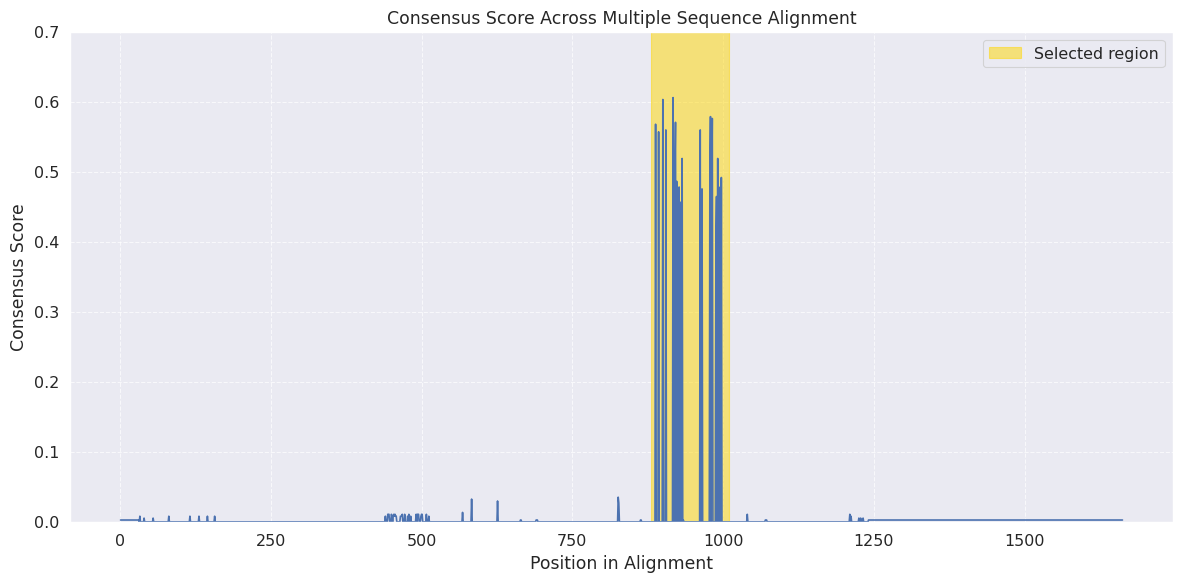

In [91]:
with sns.plotting_context("paper", font_scale=1.3):
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(scores) + 1), scores)
    plt.xlabel('Position in Alignment')
    plt.ylabel('Consensus Score')
    plt.title('Consensus Score Across Multiple Sequence Alignment')
    plt.ylim(0, 0.7)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.fill_between([c_term_start, c_term_end], 0, 0.7, color="gold", label="Selected region", alpha=0.5)
    plt.legend()
    # sns.kdeplot(scores, fill=True)
    # plt.show()
    plt.savefig('msa.svg')

In [101]:
# Color scheme for amino acids
aa_colors = {
    'A': '#FF9966', 'C': '#FFCC00', 'D': '#FF0000', 'E': '#CC0033',
    'F': '#00FF00', 'G': '#FF9999', 'H': '#0066CC', 'I': '#66CC99',
    'K': '#6600CC', 'L': '#33CC00', 'M': '#00FFFF', 'N': '#CC00CC',
    'P': '#FFCC99', 'Q': '#FF00CC', 'R': '#0000FF', 'S': '#FF3300',
    'T': '#FF6600', 'V': '#99CC00', 'W': '#00CCFF', 'Y': '#66CCFF',
    '-': '#FFFFFF', '.': '#FFFFFF', '*': '#000000'  # Gap, insertion, and stop codon
}

def compute_alignment_scores(alignment):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        summary_align = AlignInfo.SummaryInfo(alignment)
        consensus = summary_align.dumb_consensus()
    
    scores = []
    for record in alignment:
        score = sum(1 for a, b in zip(record.seq, consensus) if a == b)
        scores.append((score, record))
    
    # Sort by score in descending order
    return sorted(scores, key=lambda x: x[0], reverse=True)

def msa_to_color_matrix(sorted_alignment):
    # Convert alignment to uppercase
    alignment = [str(record.seq).upper() for _, record in sorted_alignment]
    
    # Get dimensions of the alignment
    num_sequences = len(alignment)
    seq_length = len(alignment[0])
    
    # Create a 3D numpy array to hold RGB values
    color_matrix = np.zeros((num_sequences, seq_length, 3))
    
    for i, seq in enumerate(alignment):
        for j, aa in enumerate(seq):
            color = aa_colors.get(aa, '#FFFFFF')  # Default to white for unknown residues
            color_matrix[i, j] = [int(color[k:k+2], 16) / 255.0 for k in (1, 3, 5)]
    
    return color_matrix


sorted_alignment = compute_alignment_scores(msa)
color_matrix = msa_to_color_matrix(sorted_alignment)


In [136]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 15), gridspec_kw={'height_ratios': [0.5, 2]})  # Adjust size as needed
im = ax2.imshow(color_matrix, aspect='auto', interpolation='nearest')
ax2.set_yticks([])
# # Set title
# plt.title("Multiple Sequence Alignment", fontsize=16, pad=20)

# # Set x-axis label and ticks
ax2.set_xlabel("Sequence Position", labelpad=10)
# ax.set_xticks(np.arange(0, color_matrix.shape[1], 50))  # Adjust step size as needed
# ax.set_xticklabels(np.arange(1, color_matrix.shape[1]+1, 50))

# # Set y-axis label and ticks
ax2.set_ylabel("Sequences (sorted by alignment score)", labelpad=10)
# plt.fill_between([c_term_start, c_term_end], 0, color_matrix.shape[1], color="gold", label="Selected region", alpha=0.5)
ax2.set_xlim(0, msa.get_alignment_length())
# ax.set_yticks(np.arange(color_matrix.shape[0]))
# ax.set_yticklabels([f"{score}" for score, _ in sorted_alignment])

# # Add alignment scores as text on the left side of the plot
# for i, (score, record) in enumerate(sorted_alignment):
#     ax.text(-0.01, i, f"{record.id}", va='center', ha='right', fontsize=8, transform=ax.transAxes)

# # Add colorbar
# cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.02)
# cbar.set_ticks([])  # Remove ticks
# cbar.set_label('Amino Acid Identity', rotation=270, labelpad=15)

# # Add color legend
# legend_elements = [plt.Rectangle((0, 0), 1, 1, fc=color, ec="none", label=aa) 
#                     for aa, color in aa_colors.items() if aa not in ['-', '.', '*']]
# ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), 
#             ncol=2, fontsize=8, title="Amino Acids")
sns.despine(ax=ax2, left=True)
 

with sns.plotting_context("paper", font_scale=1.3):
    sns.set_style("ticks")
    plt.subplot(211)
    plt.plot(range(1, len(scores) + 1), scores)
    # plt.xlabel('Position in Alignment')
    plt.xlim(0, msa.get_alignment_length())
    plt.xticks([])
    plt.ylabel('Consensus Score')
    plt.title('Consensus Score Across Multiple Sequence Alignment', fontsize=20)
    plt.ylim(0, 0.7)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.fill_between([c_term_start, c_term_end], 0, 0.7, color="gold", label="Selected region", alpha=0.5)
    plt.legend()
    sns.despine(ax=ax1, bottom=True, left=True)


# remove margin between top and bottom figures


plt.subplots_adjust(wspace=0, hspace=0.01)
# plt.tight_layout()
# plt.show()
# plt.savefig(output_file, dpi=300, bbox_inches='tight')
# plt.close()
plt.savefig("msa.svg")
plt.close()

In [7]:
# create a table from meme results, shwoing motif's number of occurances and confidence

meme_xml = ET.parse("../data/utp-data/meme/meme_gb.xml")
root = meme_xml.getroot()

sites = meme_xml.findall(".//scanned_sites")
scanned_sites = defaultdict(list)
sequence_ids = set()
for site in sites:
    sequence_ids.add(site.attrib["sequence_id"])
    for tag in site:
        scanned_sites[tag.attrib["motif_id"]].append(site.attrib["sequence_id"])

motifs = []
for motif in root.iter("motif"):
    motif_id = motif.attrib["id"]
    if motif_id.endswith("9"):
        continue
    motif_width = len(motif.attrib["name"])
    motif_sites = len(scanned_sites[motif_id])
    motif_e_value = float(motif.attrib["e_value"])
    motifs.append((motif_width, motif_sites, motif_e_value))
    
total_sequences = len(sequence_ids)

meme_df = pd.DataFrame(motifs, columns=["Width", "Sites", "E-value"])
meme_df["Sites"] = ((meme_df["Sites"] / total_sequences) * 100).apply(lambda x: f"{x:.0f}%")
meme_df["E-value"] = meme_df["E-value"].apply(lambda x: f"{x:.2e}")
meme_df

,Width,Sites,E-value
0,21,93%,2.10e-87
1,13,91%,1.90e-79
2,10,72%,2.80e-54
3,16,42%,1.50e-38
4,8,35%,8.10e-12
5,13,21%,2.30e-09
6,8,26%,1.40e-08
7,8,5%,1.90e+00
8,18,13%,5.20e-02


## Plot relative positions of motifs


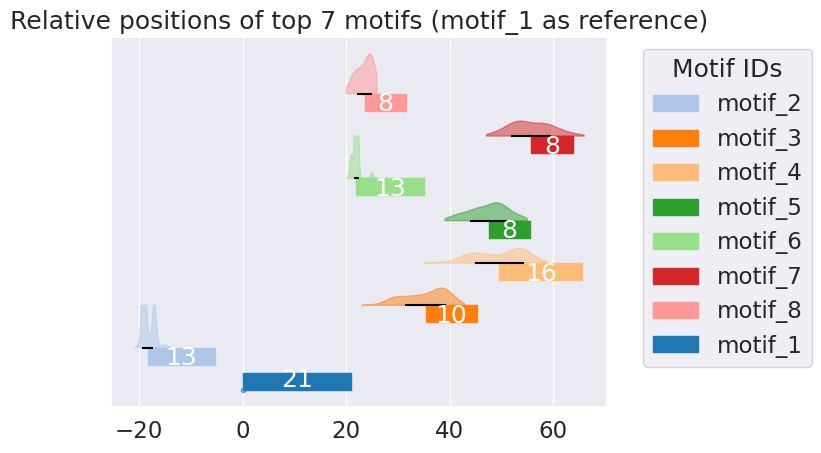

In [3]:
def parse_xml_motifs(file_path):
    meme_xml = ET.parse(file_path)
    return meme_xml


def extract_scanned_sites(meme_xml):
    sites = meme_xml.findall(".//scanned_sites")
    scanned_sites = [
        (tag.attrib["sequence_id"], site.attrib)
        for tag in sites
        for site in tag.findall("scanned_site")
    ]
    return scanned_sites


def compute_relative_positions(scanned_sites, reference_motif="motif_1"):
    motif1_positions = {
        seq: int(motif["position"])
        for seq, motif in scanned_sites
        if motif["motif_id"] == reference_motif
    }
    relative_position_occurrances = [
        (seq, motif["motif_id"], int(motif["position"]) - motif1_positions[seq])
        for seq, motif in scanned_sites
        if seq in motif1_positions and motif["motif_id"] != reference_motif
    ]
    return relative_position_occurrances


def plot_motif_positions(
    relative_position_occurrances, meme_xml, top_n=5, plot_density=True
):
    motifs = sorted(
        list(set((motif for _, motif, _ in relative_position_occurrances))),
        key=lambda motif: int(motif.split("_")[1]),
    )

    relative_positions = [[] for _ in motifs]
    for _, motif_id, rel_pos in relative_position_occurrances:
        relative_positions[motifs.index(motif_id)].append(rel_pos)

    motif_seqs = {
        tag.attrib["id"]: tag.attrib["name"] for tag in meme_xml.findall(".//motif")
    }
    cmap = matplotlib.colormaps["tab20"]
    _, ax = plt.subplots()

    for idx, motif in enumerate(motifs):
        if idx >= top_n:
            break
        rel_pos = relative_positions[motifs.index(motif)]
        mean_pos = np.mean(rel_pos)
        std_pos = np.std(rel_pos)

        base_y = idx + 1
        rect = plt.Rectangle(
            (mean_pos, base_y - 0.4),
            width=len(motif_seqs[motif]),
            height=0.4,
            color=cmap(base_y),
            label=motif,
        )
        ax.add_patch(rect)
        ax.text(
            mean_pos + len(motif_seqs[motif]) / 2,
            base_y - 0.25,
            f"{len(motif_seqs[motif])}",
            ha="center",
            va="center",
            color="white",
        )

        ax.hlines(base_y, mean_pos - std_pos, mean_pos + std_pos, color="black")

        if plot_density:
            kde = gaussian_kde(rel_pos)
            x = np.linspace(min(rel_pos) - 1, max(rel_pos) + 1, 100)
            y = kde(x) * 4
            y = np.clip(y, 0, 1)
            y[0] = 0
            y[-1] = 0
            ax.fill(x, base_y + y, color=cmap(base_y), alpha=0.5)

    # Draw reference motif
    rect = plt.Rectangle(
        (0, 0),
        width=len(motif_seqs["motif_1"]),
        height=0.4,
        color=cmap(0),
        label="motif_1",
    )
    ax.add_patch(rect)
    plt.scatter(0, 0, color=cmap(0), alpha=0.5, s=10)
    ax.text(
        len(motif_seqs["motif_1"]) / 2,
        0.25,
        f"{len(motif_seqs['motif_1'])}",
        ha="center",
        va="center",
        color="white",
    )
    # ax.vlines(len(motif_seqs["motif_1"]), 0, len(top_5_mean_positions)+1, color=cmap(0), linestyle="--", alpha=0.5)
    # ax.vlines(0, 0, len(top_5_mean_positions)+1, color=cmap(0), linestyle="--", alpha=0.5)
    
    # disable y ticks
    ax.yaxis.set_visible(False)

    ax.set_title(f"Relative positions of top {top_n} motifs (motif_1 as reference)")
    ax.legend(title="Motif IDs", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()


file_path = "../data/utp-data/meme/meme_gb.xml"
meme_xml = parse_xml_motifs(file_path)
scanned_sites = extract_scanned_sites(meme_xml)
relative_position_occurrances = compute_relative_positions(scanned_sites)
plot_motif_positions(
    relative_position_occurrances, meme_xml, top_n=7, plot_density=True
)

In [77]:
len([m for m in  relative_position_occurrances if m[1].endswith("_2")])

184

## Plot the number of occurrences of each motif combination

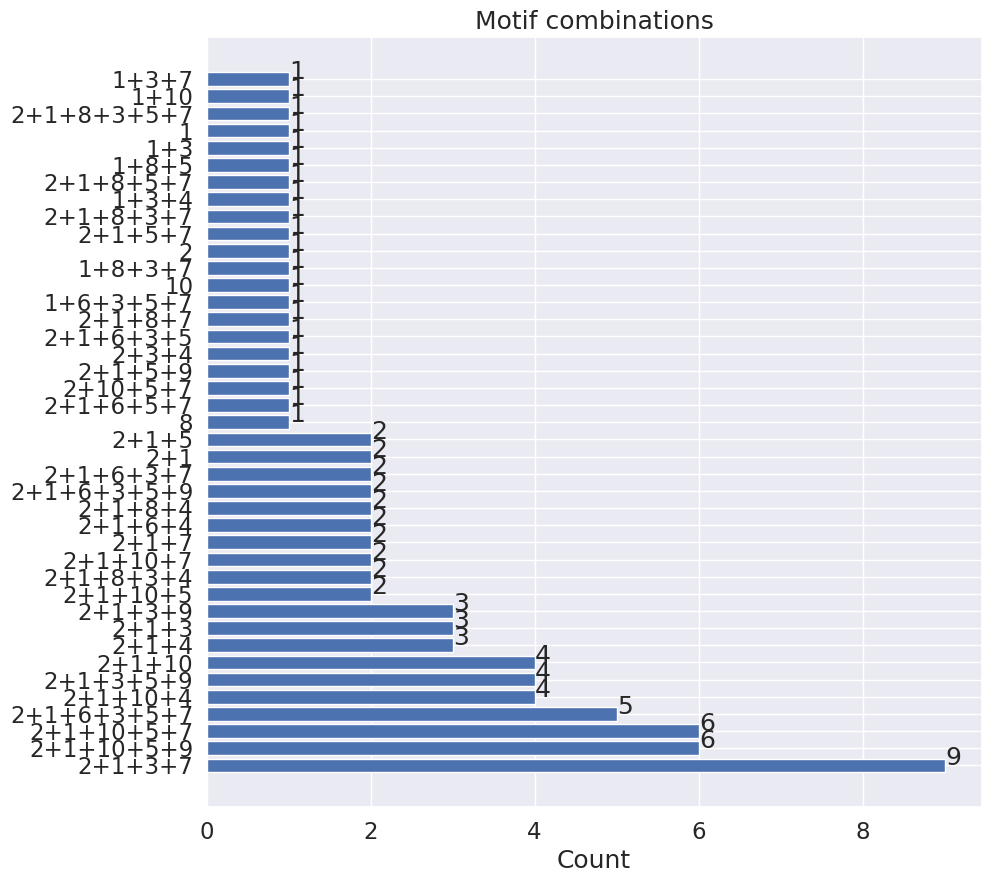

In [4]:
file_path = "../data/utp-data/meme/meme_gb.xml"
meme_xml = parse_xml_motifs(file_path)
scanned_sites = extract_scanned_sites(meme_xml)

sequences = defaultdict(list)
for seq, motif in scanned_sites:
    sequences[seq].append(motif)
sequences = {
    seq: sorted(motifs, key=lambda motif: int(motif["position"]))
    for seq, motifs in sequences.items()
}
motif_names = {
    tag.attrib["id"]: tag.attrib["name"] for tag in meme_xml.findall(".//motif")
}

motif_combinations = [
    (seq, tuple([motif["motif_id"] for motif in motifs]))
    for seq, motifs in sequences.items()
]
motif_combination_counts = Counter(
    [tuple([motif["motif_id"] for motif in motifs]) for motifs in sequences.values()]
)
motif_combinations_ids = {
    "+".join(m.split("_")[1] for m in motifs): count
    for motifs, count in motif_combination_counts.items()
    if count < 10
}

motif_combinations_ids = dict(sorted(motif_combinations_ids.items(), key=lambda x: x[1], reverse=True))

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)
ax1.barh(list(motif_combinations_ids.keys()), list(motif_combinations_ids.values()))

# show counts on bars
for i, v in enumerate(motif_combinations_ids.values()):
    ax1.text(v + 0.1, i, str(v), ha="center")

# ax.set_xticks(range(len(motif_combinations_ids)), list(motif_combinations_ids.keys()), rotation=60, ha="right" )

ax1.set_xlabel("Count")
ax1.set_title("Motif combinations")
plt.show()

## Draw the distribution of the most common motif combinations

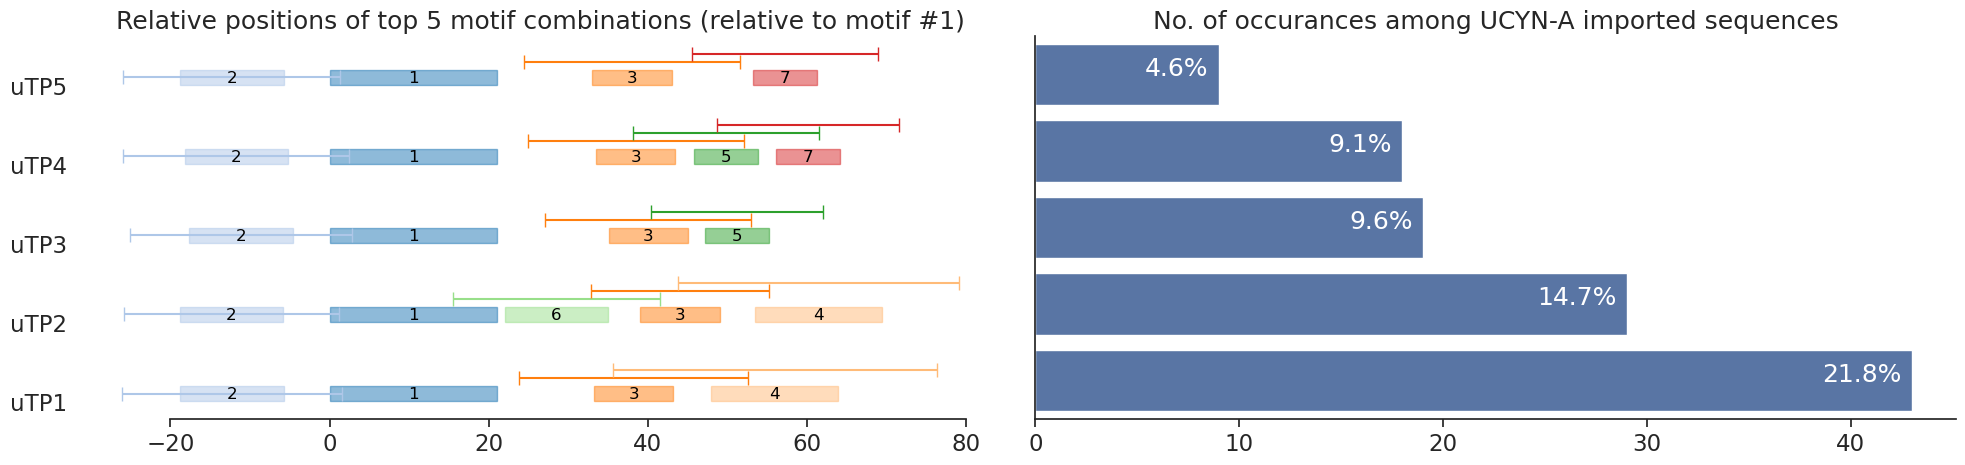

In [5]:
sns.set_style("ticks", {"ytick.left": False})

# Draw the most common motif combinations
top_n = 5
most_common_combinations = sorted(motif_combination_counts.keys(), key=lambda comb: motif_combination_counts[comb], reverse=True)
most_common_combinations = most_common_combinations[:top_n]

cmap = matplotlib.colormaps["tab20"]
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(121)

    
motif_seqs = {tag.attrib["id"]: tag.attrib["name"] for tag in meme_xml.findall('.//motif')}
motif_names = sorted(list(set(( m for m in motif_seqs.keys()  ))), key=lambda motif: int(motif.split("_")[1]))

yh = 1
label_w = 10
for base_y, comb in enumerate(most_common_combinations):
    comb_idx = base_y + 1
    base_y *= yh
    # comb_name = "+".join(comb)
    # comb_count = motif_combinations[comb]
    
    comb_occurances = [ motifs for _, motifs in sequences.items() if tuple([motif["motif_id"] for motif in motifs]) == comb ]
    relative_positions = defaultdict(list)
    for motifs in comb_occurances:
        motif1 = next((motif for motif in motifs if motif["motif_id"] == "motif_1"), None)
        assert motif1 is not None, "Motif 1 not found"
        for motif in motifs:
            if motif["motif_id"] == "motif_1":
                continue
            rel_pos = int(motif["position"]) - int(motif1["position"])
            relative_positions[motif["motif_id"]].append(rel_pos)
    relative_positions = dict(relative_positions)
    
    # ax.hlins(base_y, 0, 1000, color="black", alpha=0.5)
    
    # ax.text(-label_w, base_y + 0.1, f"{comb_idx}", ha="center", va="center", color="black", fontweight='bold', transform=ax.transAxes)
    
    for midx, motif in enumerate(comb):
        w = len(motif_seqs[motif])
        if motif in relative_positions:
            rel_pos = np.array(relative_positions[motif])
            mean_pos = np.mean(rel_pos)
            
            motif_idx = motif_names.index(motif)
            rect = plt.Rectangle((mean_pos, base_y), width=w, height=0.2, color=cmap(motif_idx), label=motif, alpha=0.5)
            ax1.add_patch(rect)
            std = np.std(rel_pos)
            ax1.errorbar(mean_pos + w/2, base_y +(midx+1)/10, xerr=std+w, fmt='none', ecolor=cmap(motif_idx), capsize=5)
            
            ax1.scatter(mean_pos, base_y + 0.1, color=cmap(motif_idx), alpha=0.0, s=40, label=motif)
            
            ax1.vlines(mean_pos, base_y, base_y + 0.4, color="black", linestyle="--", alpha=0.0)
            
            ax1.text(mean_pos + w/2, base_y + 0.1, f"{motif_idx + 1}", ha="center", va="center", color="black", fontsize=12)
            
            
            
            # if np.all(rel_pos == rel_pos[0]):
            #     x = np.array([rel_pos[0] - 1, rel_pos[0], rel_pos[0] + 1])
            #     y = np.array([0, 1, 0])
            # else:
            #     x = np.linspace(min(rel_pos) - 5, max(rel_pos) + 5, 100)
            #     kde = gaussian_kde(rel_pos)
            #     y = kde(x) * 4
            #     y = np.clip(y, 0, yh-0.05)
            #     y[0] = 0
            #     y[-1] = 0
            # ax.fill(x, base_y + y, color=cmap(motif_idx), alpha=0.5, label=motif)
        else:
            rect = plt.Rectangle((0, base_y), width=w, height=0.2, color=cmap(0), label=motif, alpha=0.5)
            ax1.add_patch(rect)
            ax1.scatter(0, base_y + 0.1, color=cmap(0), alpha=0.0, s=40)
            ax1.text(w/2, base_y + 0.1, "1", ha="center", va="center", color="black", fontsize=12)
    

y_ticks = [ f"uTP{idx+1}" for idx in range(len(most_common_combinations)) ]
ax1.set_yticks(np.arange(0, len(most_common_combinations) * yh, yh))
ax1.set_yticklabels(y_ticks)

# turn of x ticks
# ax.xaxis.set_visible(False)

# handles, labels = ax.get_legend_handles_labels()
# unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
# unique = sorted(unique, key=lambda x: int(x[1].split("_")[1]))
# unique = [(h, f"#{m.split('_')[1]}") for h, m in unique]
# ax.legend(*zip(*unique), title="Motif IDs", loc="best")

ax1.set_title("Relative positions of top 5 motif combinations (relative to motif #1)")
sns.despine(left=True, trim=True, ax=ax1)


ax1 = plt.subplot(122)
ax1.set_title("No. of occurances among UCYN-A imported sequences")
sns.barplot([motif_combination_counts[comb] for comb in reversed(most_common_combinations)], orient="h", ax=ax1)
# Display percentage on bars
for i, v in enumerate([motif_combination_counts[comb] for comb in reversed(most_common_combinations)]):
    v_p = v / len(sequences) * 100
    ax1.text(v - 0.5, i, f"{v_p:.1f}%", ha="right", fontsize=18, color="white")
ax1.set_yticks([])
sns.despine(ax=ax1)


plt.tight_layout()
# plt.show()
plt.savefig("../motif-combinations.svg")

## Analyze space between motifs

In [26]:
seqs = {s.id: str(s.seq) for s in SeqIO.parse("../data/utp-data/good-c-term-full.fasta", "fasta")}

seq_names = { tag.attrib["id"]: tag.attrib["name"] for tag in meme_xml.findall('.//sequence') }
seq_motifs = { seq_name: sequences[seq_id] for seq_id, seq_name in seq_names.items() if seq_id in sequences }
seq_motifs = { seq_name: sorted(motifs, key=lambda motif: int(motif["position"])) for seq_name, motifs in seq_motifs.items() }
seq_motifs_with_pos = { seq_name: [(motif["motif_id"], int(motif["position"])) for motif in motifs] for seq_name, motifs in seq_motifs.items() }

annotated_seqs = {}
for seq_name, motifs in seq_motifs_with_pos.items():
    seq = seqs[seq_name]
    annotated_seq = []
    last_pos = -1
    for motif, pos in motifs:
        mofif_len = len(motif_seqs[motif])
        annotated_seq.append(seq[last_pos+1:pos])
        annotated_seq.append(f"[{motif}]")
        last_pos = pos+mofif_len
    annotated_seq.append(seq[last_pos+1:])
    annotated_seq = [seq for seq in annotated_seq if seq != ""]
    annotated_seqs[seq_name] = annotated_seq

in_between_motifs = defaultdict(list)
for annotated_seq in annotated_seqs.values():
    prev_motif = None
    prev_seq = None
    for seq in annotated_seq:
        if seq.startswith("["):
            motif = seq[1:-1]
            if prev_motif is not None and prev_seq is not None:
                in_between_motifs[(prev_motif, motif)].append(prev_seq)
            prev_motif = motif
        else:
            prev_seq = seq

aa_dist = { k: Counter("".join(v)) for k, v in in_between_motifs.items() }
mean_len = { k: np.mean([len(seq) for seq in v]) for k, v in in_between_motifs.items() }

In [27]:
def sample_aa_dist(n, aa_dist):
    choices = "".join([k*v for k, v in aa_dist.items()])
    aa = np.random.choice(list(choices), n)
    return "".join(aa)

In [28]:
def construct_utp(motifs_to_use):
    seq = []
    for motif1, motif2 in zip(motifs_to_use[:-1], motifs_to_use[1:]):
        seq.append(f"{motif_seqs[motif1]}")
        seq.append(sample_aa_dist(round(mean_len[(motif1, motif2)]), aa_dist[(motif1, motif2)]))
    seq.append(motif_seqs[motifs_to_use[-1]])
    return "".join(seq)

construct_utp(most_common_combinations[0])

'WLEEWRERLECWWAGDNTQTQLGACMGALGLHLGSRLDEHDVFQEWAHPGAEPGCEWVEEHDAWLPDFPEPFSLPPIPRL'

## Create motif tree

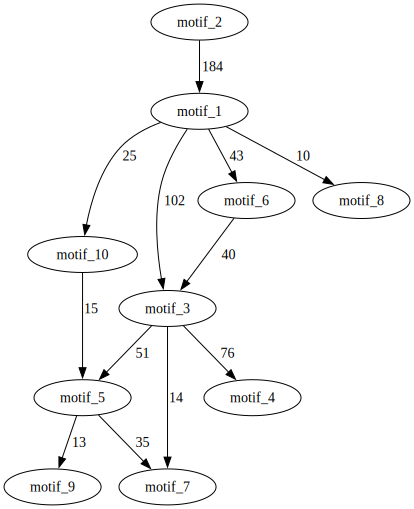

In [10]:
import graphviz

motif_tree = Counter(
    [
        (motif1["motif_id"], motif2["motif_id"])
        for motifs in sequences.values()
        for motif1, motif2 in zip(motifs[:-1], motifs[1:])
    ]
)
motif_tree = {
    (motif1, motif2): count
    for (motif1, motif2), count in motif_tree.items()
    if count > 5
}

dot = graphviz.Digraph()
for motif1, motif2 in motif_tree:
    dot.edge(motif1, motif2, label=str(motif_tree[(motif1, motif2)]))
dot

## Analyze relationship between motifs and the mature domain

In [10]:
seqs = list(SeqIO.parse("../data/utp-data/good-c-term-full.fasta", "fasta"))

seq_names = { tag.attrib["id"]: tag.attrib["name"] for tag in meme_xml.findall('.//sequence') }
seq_motifs = { seq_name: sequences[seq_id] for seq_id, seq_name in seq_names.items() if seq_id in sequences }
seq_motifs = { seq_name: sorted(motifs, key=lambda motif: int(motif["position"])) for seq_name, motifs in seq_motifs.items() }
seq_motifs_with_pos = { seq_name: [(motif["motif_id"], int(motif["position"])) for motif in motifs] for seq_name, motifs in seq_motifs.items() }
seq_motifs = { seq_name: [motif["motif_id"] for motif in motifs] for seq_name, motifs in seq_motifs.items() }

In [11]:
# Test whether the mature domain can predict the motif sequence
mature_domains = {
    seq.id: str(seq.seq)[:c_term_start] for seq in seqs if seq.id in seq_motifs
}

dataset = [
    (mature_domains[seqid], seq_motifs[seqid]) for seqid in seq_motifs if len(seq_motifs[seqid]) > 0
]

In [3]:
tokenizer = T5Tokenizer.from_pretrained(
    "Rostlab/prot_t5_xl_uniref50", do_lower_case=False
)
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")
gc.collect()

def embed_sequences(sequences, device="cpu"):
    feat_list = []
    for seq in tqdm(sequences):
        seq_list = []
        seq = re.sub(r"\*", "", seq)
        slen = len(seq)
        #            sequences.append(" ".join(str(fasta.seq)))
        seq_list.append(" ".join(seq))
        # map rarely occured amino acids (U,Z,O,B) to (X)
        seq_list = [
            re.sub(r"[UZOJB]", "X", sequence) for sequence in seq_list
        ]
        # Tokenize, encode seq_list and load it into the GPU if possibile
        ids = tokenizer.batch_encode_plus(
            seq_list, add_special_tokens=True, padding=True
        )
        input_ids = torch.tensor(ids["input_ids"]).to(device)
        attention_mask = torch.tensor(ids["attention_mask"]).to(device)
        # Extracting sequence features and load it into the CPU if needed
        with torch.no_grad():
            embedding = model(
                input_ids=input_ids, attention_mask=attention_mask
            )
        embedding = embedding.last_hidden_state.cpu().numpy()
        # Remove padding (\<pad>) and special tokens (\</s>) that is added by ProtT5-XL-UniRef50 model
        features = []
        for seq_num in range(len(embedding)):
            seq_len = (attention_mask[seq_num] == 1).sum()
            seq_emd = embedding[seq_num][: seq_len - 1]
            features.append(seq_emd)

        features = np.array(features).astype(float).reshape(slen, 1024)
        feat_list.append(features)
    return feat_list

In [12]:
if os.path.exists("../data/utp-data/mature-embeddings.h5"):
    with h5py.File("../data/utp-data/mature-embeddings.h5", "r") as f:
        mature_embeddings_unordered = []
        for key in f.keys():
            idx, _ = key.split("_", 1)
            mature_embeddings_unordered.append((idx, f[key][()]))
        mature_embeddings = [None] * len(mature_embeddings_unordered)
        for idx, feat in mature_embeddings_unordered:
            mature_embeddings[int(idx)] = feat
else:
    mature_embeddings = embed_sequences([s for s, _ in dataset])
    with h5py.File("../data/utp-data/mature-embeddings.h5", "w") as f:
        for idx, seqid in enumerate(seq_motifs):
            if len(seq_motifs[seqid]) == 0:
                continue
            feat = mature_embeddings[idx]
            f.create_dataset(f"{idx}_{seqid}", data=feat)


### Train embeddings classifier

In [13]:
X = np.array([np.mean(feat, axis=0) for feat in mature_embeddings])

motif_labels = list(set((tuple(comb) for comb in seq_motifs.values())))
Y = np.array([ motif_labels.index(tuple(comb)) for _, comb in dataset ])
Y_counts = Counter(Y)
# use only motifs that have at least 10 occurances, 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC()
]

test_results = {}
for classifier in classifiers:
    classifier.fit(X_train, Y_train)
    
    Y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    
    n = len(Y_test)
    p = 1 / len(motif_labels)
    alternative = 'greater'
    p_value = binomtest(round(accuracy * n), n, p, alternative=alternative)
    
    test_results[classifier.__class__.__name__] = {
        "accuracy": accuracy,
        "p_value": p_value.pvalue
    }
        

for classifier, accuracy in test_results.items():
    print(f"{classifier}: {accuracy}")
    
best_embedding_classifier = max(test_results, key=lambda x: test_results[x]["accuracy"])
best_embedding_classifier = [c for c in classifiers if c.__class__.__name__ == best_embedding_classifier][0]
joblib.dump(best_embedding_classifier, "../data/utp-data/best-embedding-classifier.joblib")

LogisticRegression: {'accuracy': 0.325, 'p_value': 2.2104365467748996e-12}
DecisionTreeClassifier: {'accuracy': 0.1, 'p_value': 0.011789618138990059}
RandomForestClassifier: {'accuracy': 0.275, 'p_value': 8.316769727458918e-10}
SVC: {'accuracy': 0.275, 'p_value': 8.316769727458918e-10}


['../data/utp-data/best-embedding-classifier.joblib']

In [27]:
from sklearn.model_selection import permutation_test_score

X = np.array([np.mean(feat, axis=0) for feat in mature_embeddings])
motif_labels = list(set((tuple(comb) for comb in seq_motifs.values())))
Y = np.array([motif_labels.index(tuple(comb)) for _, comb in dataset])
Y_counts = Counter(Y)

# Use only motifs that have at least 10 occurrences
min_occurrences = 10
valid_motifs = [motif for motif, count in Y_counts.items() if count >= min_occurrences]
mask = np.isin(Y, valid_motifs)
X = X[mask]
Y = Y[mask]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

classifiers = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC()
]

test_results = {}

for classifier in classifiers:
    # Fit the classifier
    classifier.fit(X_train, Y_train)
    
    # Calculate accuracy on test set
    Y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    
    # Perform permutation test
    score, perm_scores, pvalue = permutation_test_score(
        classifier, X, Y, 
        scoring="accuracy", 
        cv=5,  # 5-fold cross-validation
        n_permutations=1000,
        n_jobs=-1  # Use all available cores
    )
    
    # Calculate binomial test p-value
    n = len(Y_test)
    p = 1 / len(set(Y))
    binomial_pvalue = binomtest(round(accuracy * n), n, p, alternative='greater').pvalue
    
    test_results[classifier.__class__.__name__] = {
        "accuracy": accuracy,
        "permutation_score": score,
        "all_permutation_scores": perm_scores,
        "permutation_p_value": pvalue,
        "binomial_p_value": binomial_pvalue
    }

# Print results
for classifier, results in test_results.items():
    print(f"{classifier}:")
    print(f"  Accuracy: {results['accuracy']:.4f}")
    print(f"  Permutation Score: {results['permutation_score']:.4f}")
    print(f"  Permutation p-value: {results['permutation_p_value']:.4f}")
    print(f"  Binomial p-value: {results['binomial_p_value']:.4f}")
    print()

LogisticRegression:
  Accuracy: 0.6818
  Permutation Score: 0.5411
  Permutation p-value: 0.0010
  Binomial p-value: 0.0000

DecisionTreeClassifier:
  Accuracy: 0.0909
  Permutation Score: 0.3662
  Permutation p-value: 0.0380
  Binomial p-value: 0.9851

RandomForestClassifier:
  Accuracy: 0.6818
  Permutation Score: 0.5316
  Permutation p-value: 0.0010
  Binomial p-value: 0.0000

SVC:
  Accuracy: 0.4545
  Permutation Score: 0.5320
  Permutation p-value: 0.0010
  Binomial p-value: 0.0295



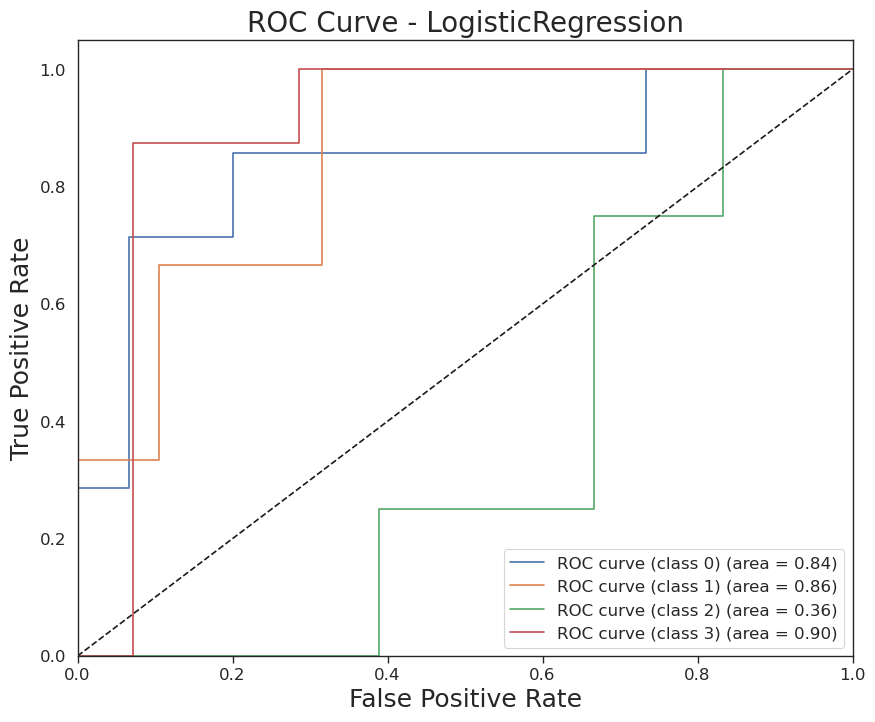

In [49]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# # 1. Bar plot of accuracies
# plt.figure(figsize=(10, 6))
accuracies = [results['accuracy'] for results in test_results.values()]
classifier_names = list(test_results.keys())
# plt.bar(classifier_names, accuracies)
# plt.title('Accuracy Comparison of Classifiers')
# plt.xlabel('Classifier')
# plt.ylabel('Accuracy')
# plt.ylim(0, 1)
# plt.savefig('accuracy_comparison.png')
# plt.close()

# # 2. Permutation test results visualization
# plt.figure(figsize=(12, 6))
# for i, (name, results) in enumerate(test_results.items()):
#     sns.kdeplot(results['all_permutation_scores'], shade=True, label=name)
#     plt.axvline(results['accuracy'], color='r', linestyle='--', label='Actual accuracy' if i == 0 else '')
# plt.title('Permutation Test Results')
# plt.xlabel('Accuracy')
# plt.ylabel('Density')
# plt.legend()
# plt.savefig('permutation_test_results.png')
# plt.close()

# # 3. Confusion Matrix (for the best classifier)
best_classifier = max(test_results, key=lambda x: test_results[x]["accuracy"])
y_pred = classifiers[classifier_names.index(best_classifier)].predict(X_test)
# cm = confusion_matrix(Y_test, y_pred)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.title(f'Confusion Matrix - {best_classifier}')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.savefig('confusion_matrix.png')
# plt.close()

# 4. ROC Curve (for multi-class, one-vs-rest)
y_bin = label_binarize(Y_test, classes=np.unique(Y))
n_classes = y_bin.shape[1]
y_score = classifiers[classifier_names.index(best_classifier)].predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

params = {'axes.labelsize': 18,'axes.titlesize':20, 'font.size': 20, 'legend.fontsize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12}
matplotlib.rcParams.update(params)
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_classifier}')
plt.legend(loc="lower right")

# plt.show()
plt.savefig('roc_curve.svg')

In [60]:
# Create pd table with classification results: accuracy, permutation score, permutation p-value, F1 score

# 1. compute F1 score
from sklearn.metrics import f1_score

f1_scores = []
for classifier in classifiers:
    classifier.fit(X_train, Y_train)
    Y_pred = classifier.predict(X_test)
    f1 = f1_score(Y_test, Y_pred, average='weighted')
    f1_scores.append(f1)
    
# 2. create pd table
results = pd.DataFrame(test_results).T
results['F1 Score'] = f1_scores
del results['all_permutation_scores']
del results['binomial_p_value']
del results['permutation_score']
results.columns = ['Accuracy', 'Permutation p-value', 'F1 Score']

# rename index
results.index = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVC']

# sort by accuracy
results = results.sort_values(by='Accuracy', ascending=False)

# format numbers
results['Accuracy'] = results['Accuracy'].apply(lambda x: f'{x*100:.0f}%')
results['Permutation p-value'] = results['Permutation p-value'].apply(lambda x: f'{x:.4f}')
results['F1 Score'] = results['F1 Score'].apply(lambda x: f'{x:.2f}')

# print csv to stdout
results

,Accuracy,Permutation p-value,F1 Score
Logistic Regression,68%,0.0010,0.61
Random Forest,68%,0.0010,0.49
SVC,45%,0.0010,0.34
Decision Tree,9%,0.0380,0.13


In [5]:
if os.path.exists("../data/utp-data/best-embedding-classifier.joblib"):
    best_embedding_classifier = joblib.load("../data/utp-data/best-embedding-classifier.joblib")

/home/mablin/micromamba/envs/nitroblast/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.4.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
def predict_motifs(seq):
    feat = embed_sequences([seq])[0]
    feat = np.mean(feat, axis=0)
    pred = best_embedding_classifier.predict([feat])
    return motif_labels[pred[0]]

## Create protein+transit peptide contstructs

In [29]:
m_neon_green = "MVSKGEEDNMASLPATHELHIFGSINGVDFDMVGQGTGNPNDGYEELNLKSTKGDLQFSPWILVPHIGYGFHQYLPYPDGMSPFQAAMVDGSGYQVHRTMQFEDGASLTVNYRYTYEGSHIKGEAQVKGTGFPADGPVMTNSLTAADWCRSKKTYPNDKTIISTFKWSYTTGNGKRYRSTARTTYTFAKPMAANYLKNQPMYVFRKTELKHSKTELNFKEWQKAFTDVMGMDELYK"

m_venus = "MVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKLICTTGKLPVPWPTLVTTLGYGLQCFARYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYITADKQKNGIKANFKIRHNIEDGGVQLADHYQQNTPIGDGPVLLPDNHYLSYQSKLSKDPNEKRDHMVLLEFVTAAGITLGMDELYK"

In [32]:
candidates = {
    "m_venus": {
        motifs: m_venus + construct_utp(motifs) for motifs in most_common_combinations
    },
    "m_neon_green": {
        motifs: m_neon_green + construct_utp(motifs) for motifs in most_common_combinations
    }
}

In [34]:
for motifs in most_common_combinations:
    print(f"Motifs: {motifs}")
    print(f"{construct_utp(motifs)}")

Motifs: ('motif_2', 'motif_1', 'motif_3', 'motif_4')
WLEEWRERLECWWSKSLTQTQLGACMGALGLHLGSRLDLGWSEPAPASMSAEPGCEWVEESDSALPDFPEPFSLPPIPRL
Motifs: ('motif_2', 'motif_1', 'motif_6', 'motif_3', 'motif_4')
WLEEWRERLECWWDPEKTQTQLGACMGALGLHLGSRLDTEAKGAWRAALLGRAPPPHMTAEPGCEWVEETEPALPDFPEPFSLPPIPRL
Motifs: ('motif_2', 'motif_1', 'motif_3', 'motif_5')
WLEEWRERLECWWAKRFTQTQLGACMGALGLHLGSRLDRDWGGGLSSECIAEPGCEWVEELEEHAALZLPDFPD
Motifs: ('motif_2', 'motif_1', 'motif_3', 'motif_5', 'motif_7')
WLEEWRERLECWWAMVATQTQLGACMGALGLHLGSRLDPETPWRVDFQQEAEPGCEWVEEQERGPELZLPDFPDAPPJPRLLP
Motifs: ('motif_2', 'motif_1', 'motif_3', 'motif_7')
WLEEWRERLECWWGADRTQTQLGACMGALGLHLGSRLDEDAFQEANGMSLAEPGCEWVEEMTVLDSGEWPPJPRLLP


In [7]:
def create_utp(seq):
    motifs = predict_motifs(seq)
    utp = construct_utp(motifs)
    return utp

create_utp(m_neon_green)

NameError: name 'embed_sequences' is not defined

### Train amino acid composition classifier

In [54]:
AA_alphabet = list("ABCDEFGHIJKLMNOPQRSTUVWYZX")

AA_comp = []
for seq in [s for s, _ in dataset]:
    aa = []
    for a in AA_alphabet:
        aa.append(seq.count(a))
    AA_comp.append(aa)
AA_comp = np.array(AA_comp)

In [56]:
X = AA_comp
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

classifiers = [
    # LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC()
]

test_results = {}
for classifier in classifiers:
    classifier.fit(X_train, Y_train)
    
    Y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    
    n = len(Y_test)
    p = 1 / len(motif_labels)
    alternative = 'greater'
    p_value = binomtest(round(accuracy * n), n, p, alternative=alternative)
    
    test_results[classifier.__class__.__name__] = {
        "accuracy": accuracy,
        "p_value": p_value.pvalue
    }
        

for classifier, accuracy in test_results.items():
    print(f"{classifier}: {accuracy}")
    
best_classifier = RandomForestClassifier()

DecisionTreeClassifier: {'accuracy': 0.075, 'p_value': 0.058996511791500186}
RandomForestClassifier: {'accuracy': 0.2, 'p_value': 2.4216833200738525e-06}
SVC: {'accuracy': 0.175, 'p_value': 2.6188259288855507e-05}
